# Training a nonlinear RNN with tensorflow

[Tensorflow](https://www.tensorflow.org/) is a popular framework for [deep learning](https://en.wikipedia.org/wiki/Deep_learning), which is the basis for many [recent and exciting advances](http://www.sciencemag.org/news/2017/07/how-ai-detectives-are-cracking-open-black-box-deep-learning) in artificial intelligence.

When all is said and done, Tensorflow is basically a really great tool for handling large and complex models and computing derivatives automatically, without doing the tedious math. This means that you can very rapidly prototype different model architectures, task parameters, and optimization approaches. Another big reason to use Tensorflow, or a similar deep learning framework (e.g. [PyTorch](http://pytorch.org/)), is that they seemlessly enable your model to run on GPUs, which are super fast for linear algebra operations but can be a huge pain to code by hand.

In this problem we will explore how to train a nonlinear recurrent neural network (RNN) to do a simple version of the classic random dots direction-discrimination task ([Britten et al., 1992](https://www.ncbi.nlm.nih.gov/pubmed/1464765)). In this task, a human or animal subject sees a screen of moving dots that are a mix of random motion and coherent motion to one direction (either left or right).
The goal is to estimate which direction the dots are moving, on average.
The task becomes arbitrarily hard as the random movements are cranked up and dominate over the coherent movements.
Click this link to [watch a rat perform](https://www.youtube.com/watch?v=oDxcyTn-0os) the task.

The basic philosophy here is to train a model network (by any means necessary) to solve a task similar to the one the animal is solving. Then, we can reverse-engineer how the network solves the task and hope that this sheds light on general computational mechanisms that may transfer to real neural circuits. See [Sussillo (2014)](https://doi.org/10.1016/j.conb.2014.01.008); [Mante, Sussillo et al. (2013)](https://doi.org/10.1038/nature12742); [Song et al. (2016)](https://doi.org/10.1371/journal.pcbi.1004792); [Orhan & Ma (2017)](https://doi.org/10.1038/s41467-017-00181-8) as further references on this approach.

#### Import standard python libraries

If you aren't familiar with Python and the standard scientific computing libraries, take a look at the SciPy [Getting Started](https://www.scipy.org/getting-started.html) page. We will use the [NumPy](http://www.numpy.org/) library, which provides a comprehensive set of linear algebra operations and functions. If you are more familiar with Matlab, check out this [reference sheet](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html). We'll also use the [Matplotlib](https://matplotlib.org/) library which provides plotting functionality with very similar syntax to Matlab (hence the name). The `%matplotlib inline` command causes the plots to be embedded in the Jupyter notebook, rather than a pop-up window. It is standard to import numpy with the alias `np` and to import the matplotlib functions with the alias `plt`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### Code to generate a trial

Each trial consists of a 1-dimensional noisy time series. The input is either net positive or net negative, in analogy to the dots moving mostly to the right or the left in the behavioral task. The goal of the network is to output a positive or negative value to indicate the sign of the noisy input. 

In [2]:
# parameters for the stimulus
num_timesteps = 60
noise_stddev = 1.0

# function for generating trials
def generate_stimulus():
    """Generates a single trial.
        
    Returns:
        stimulus, numpy array/vector with size (num_timesteps,)
        target, {+1 or -1} the sign of the input (left or right dot motion)
    """
    noise = np.random.randn(num_timesteps) * noise_stddev
    stimulus = np.random.choice([-1, +1]) + noise
    target = np.sign(np.mean(stimulus))
    return stimulus, target

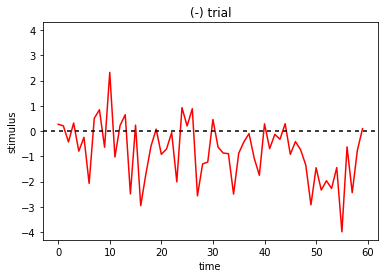

In [3]:
stim, targ = generate_stimulus()
if targ > 0:
    plt.plot(stim, '-k')
    plt.title('(+) trial')
if targ < 0:
    plt.plot(stim, '-r')
    plt.title('(-) trial')
plt.axhline(0, color='k', dashes=[2,2])
yl = np.max(np.abs(plt.ylim()))
plt.ylim([-yl, yl])
plt.ylabel('stimulus')
plt.xlabel('time')

#### Import the magic sauce.

In [4]:
import tensorflow as tf

#### Define the computational graph

The central principle of tensorflow is to represent your model as a "computational graph" which symbolically represents the computations that your model will do. That is, all tensorflow operations intially set up a contract for what you will run in the future, *they are not immediately performed.* In fact, we don't even necessarily need to tell tensorflow the actual values of our variables (see `placeholder` variables below).

In [5]:
# One quirk of tensorflow is that its garbage collection is separate from Python.
# That is, Python will delete any variable that is renamed or when it falls out
# of scope (e.g. at the end of a function), but a tensorflow variable will persist
# even if the Python reference to this variable is deleted.

# Thus, if you re-run this code to create the computational graph too many times, you
# might run out of memory! If this happens, you can run the following command (which
# should delete all tensorflow variables) or restart the Python kernel using the
# toolbars at the top.
tf.reset_default_graph()

In [6]:
# Define the computational graph of the RNN

# structure of the network
num_neurons = 100
init_scale = .1

# synaptic weights
input_weights = tf.Variable(.1 * np.random.randn(1, num_neurons))
recurrent_weights = tf.Variable(.05 * np.random.randn(num_neurons, num_neurons))
output_weights = tf.Variable(.1 * np.random.randn(num_neurons, 1))

# input to the network
u = tf.placeholder(tf.float64, shape=num_timesteps)

# target for the network {+1 or -1}
s = tf.placeholder(tf.float64)

# initial condition
x0 = tf.zeros((1, num_neurons), tf.float64)

# simulate the network
x, y = [x0], []
for t in range(num_timesteps):
    x += [tf.nn.tanh(tf.matmul(x[-1], recurrent_weights) + u[t]*input_weights)]
    y.append(tf.matmul(x[-1], output_weights))

#### Create a session

Now that the RNN is represented symbolically in tensorflow, we will run a particular instance of this model. In tensorflow this is done within a [`Session`](https://www.tensorflow.org/api_docs/python/tf/Session). The most important function of the Session is the `run()` command. Which executes computation in tensorflow and returns the result as a numpy array or other Python object. See the [getting started notebook](./getting-started.ipynb) for more information.

In [7]:
# create tensorflow session for simulation
sess = tf.Session()

# initialize variables - note that tensorflow will initialize everything except the 
# placeholder variables, which we'll get to below.
sess.run(tf.global_variables_initializer())

#### Use the session to run the computational graph

Before training the network let's see how well it does on the task. We initialized all the weights randomly, so it shouldn't work that great.

**A note on placeholders:** You'll note that tensorflow still doesn't know what the input to the network is --- i.e. we never told it what `u` is! Thus, every time you call `sess.run(...)` *and* tensorflow needs `u` for the computation you requested from it, you need to pass in the value of `u` through what is called the `feed_dict`. This will allow us to run the network with a different input signal every time we run the graph. As it's name implies the `feed_dict` is a [Python dictionary object](https://docs.python.org/3/tutorial/datastructures.html#dictionaries), which is somewhat similar to a struct in matlab. See the [getting started notebook](./getting-started.ipynb) for more information.

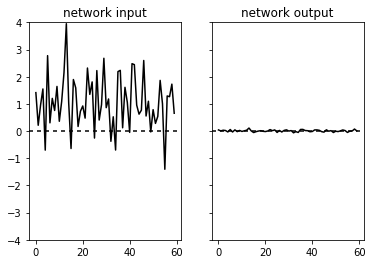

In [8]:
# run a trial
stim, targ = generate_stimulus()
out = sess.run(y, feed_dict={u: stim})
out = np.array(out).ravel()

# plot the results
fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].plot(stim, color='k' if targ > 0 else 'r')
axes[0].axhline(color='k', dashes=[2,2])
axes[0].set_title('network input')
axes[0].set_ylim([-4, 4])

axes[1].plot(out, color='k' if out[-1] > 0 else 'r')
axes[1].axhline(color='k', dashes=[2,2])
axes[1].set_title('network output')

#### Define the objective function and optimization

Tensorflow comes with a bunch of built-in optimization tools that we'll exploit. Refer to the tensorflow [documentation on training](https://www.tensorflow.org/api_guides/python/train).

In [9]:
# define loss function (logistic)
loss_function = tf.log(1 + tf.exp(-s*y[-1]))

In [10]:
# this holds information about the optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 1e-3)

# this is the training operation/command that you need to run in tensorflow after each trial
train_op = optimizer.minimize(loss_function)

#### Now train the model!

trial 1999 / 2000

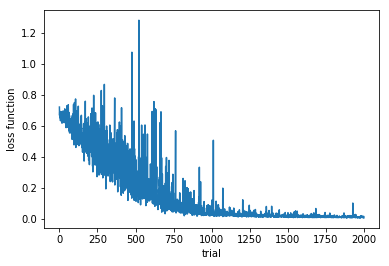

In [11]:
# number of training trials
num_trials = 2000

# the loss function over all trials
opt_history = np.empty(num_trials) 

for k in range(num_trials):
    print('\rtrial {} / {}'.format(k, num_trials), end='', flush=True)
    stim, targ = generate_stimulus()
    feed_dict = {
        u: stim,
        s: targ
    }
    opt_history[k], _ = sess.run([loss_function, train_op], feed_dict=feed_dict)

fig, ax = plt.subplots()
ax.plot(opt_history)
ax.set_ylabel('loss function')
ax.set_xlabel('trial')

#### That learning curve looks pretty good! Now plot some trials after training.

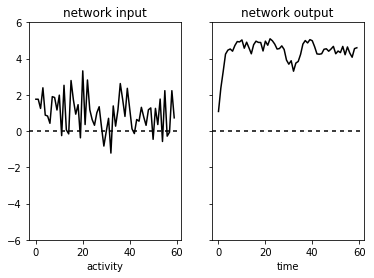

In [12]:
# run a trial
stim, targ = generate_stimulus()
out = sess.run(y, feed_dict={u: stim})
out = np.array(out).ravel()

# plot the results
fig, axes = plt.subplots(1, 2, sharey=True)

axes[0].plot(stim, color='k' if targ > 0 else 'r')
axes[0].axhline(color='k', dashes=[2,2])
axes[0].set_title('network input')
axes[0].set_ylim([-6, 6])
axes[0].set_xlabel('time')
axes[0].set_xlabel('activity')

axes[1].plot(out, color='k' if out[-1] > 0 else 'r')
axes[1].axhline(color='k', dashes=[2,2])
axes[1].set_title('network output')
axes[1].set_xlabel('time')

### Plot the internal network activity

So far, we've just plotted the output of the network, but we'd also like to understand the internal dynamics of the recurrently connected neurons. One way to plot this is with a heatmap, below.

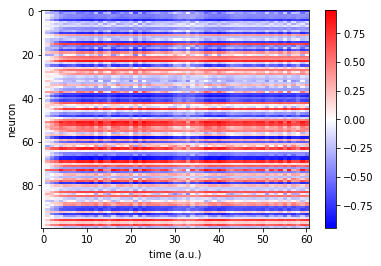

In [13]:
# plot the firing rates for the same trial (plotted above)
rates = np.squeeze(sess.run(x, feed_dict={u: stim})).T
# rates is a (neurons x time) matrix
plt.imshow(rates, cmap='bwr', aspect='auto')
plt.xlabel('time (a.u.)')
plt.ylabel('neuron')
plt.colorbar()

Huh, that seems like an interesting pattern... Can you come up with a better way to visually organize it? You can also look at the activity of individual neurons as plotted below.

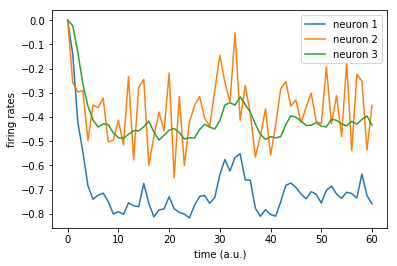

In [14]:
plt.plot(rates[0], label='neuron 1')
plt.plot(rates[1], label='neuron 2')
plt.plot(rates[2], label='neuron 3')
plt.xlabel('time (a.u.)')
plt.ylabel('firing rates')
plt.legend(loc='best')

### Plot the eigenvalues of the weight matrix

One of the nice things about reverse engineering a model like this is that you have access to more information than can be experimentally measured in real circuits. For example, below we've taken the raw weight matrix (after training) and plotted the eigenvalues in the real-complex plane. Based on this plot (and your own, additional creative analysis and visualizations!) can you come up with an explanation of how the network is working?

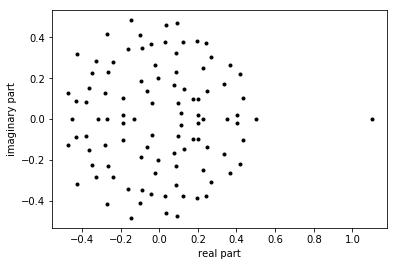

In [15]:
ev, evec = np.linalg.eig(sess.run(recurrent_weights))
plt.plot(np.real(ev), np.imag(ev), '.k')
plt.xlabel('real part')
plt.ylabel('imaginary part')

## Next steps

We'd like you to use this starter code to do something creative! Here are some suggestions:

* Try re-running this code with larger noise in the inputs. Does the network train learn to do the task? Can you modify the network or the training process to make the network handle larger amounts of noise? How much noise can you handle?<br><br>
* Try changing the stimulus so that the network needs to "remember" the stimulus for a period of time. That is, turn off coherent motion for some number of time steps before then end of the stimulus. How long of a delay period can the network handle? Can you modify the network or the training procedure to accomodate a longer delay period?<br><br>
* How does the network "learn" to do the task? You can characterize this learning in many ways. For example,<br><br>
    * What is the average percent change in the synaptic weights over the learning process? Can you modify the model or training procedure to find a network that this average percent change is minimal? <br><br>
    * How does the initial activity of a neuron in the network correlate with the activity of that neuron after the training process?